In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
import pickle
import pandas as pd
from tqdm import tqdm
# import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
import re
%matplotlib inline

# Data Cleaning & Exploration

In [2]:
data = pd.read_csv("./input/Youtube03-LMFAO.csv")

In [3]:
data.shape

(438, 5)

In [4]:
data.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,z13uwn2heqndtr5g304ccv5j5kqqzxjadmc0k,Corey Wilson,2015-05-28T21:39:52.376000,"<a href=""http://www.youtube.com/watch?v=KQ6zr6...",0
1,z124jvczaz3dxhnbc04cffk43oiugj25yzo0k,Epic Gaming,2015-05-28T20:07:20.610000,wierd but funny﻿,0
2,z13tczjy5xj0vjmu5231unho1ofey5zdk,LaS Music,2015-05-28T19:23:35.355000,"Hey guys, I&#39;m a human.<br /><br /><br />Bu...",1
3,z13tzr0hdpnayhqqc04cd3zqqqjkf3ngckk0k,Cheryl Fox,2015-05-28T17:49:35.294000,Party Rock....lol...who wants to shuffle!!!﻿,0
4,z12pcvix4zedcjvyb04ccr1r0mr2g5xwyng0k,PATRICK_TW,2015-05-28T16:28:26.818000,Party rock﻿,0


In [5]:
data["CONTENT"][13]

'2011- the last year of decent music.\ufeff'

In [6]:
data["CLASS"][13]

0

In [7]:
data["CONTENT"][401]

'Check out this video on YouTube:\ufeff'

In [9]:
data["CLASS"][401]

1

### Select only 'CONTENT' and 'CLASS' columns

In [10]:
data = data[["CONTENT", "CLASS"]]

In [11]:
data.head()

,CONTENT,CLASS
0,"<a href=""http://www.youtube.com/watch?v=KQ6zr6...",0
1,wierd but funny﻿,0
2,"Hey guys, I&#39;m a human.<br /><br /><br />Bu...",1
3,Party Rock....lol...who wants to shuffle!!!﻿,0
4,Party rock﻿,0


In [12]:
data.isna().sum()

CONTENT    0
CLASS      0
dtype: int64

### Drop records with missing comments

In [13]:
data.dropna(inplace=True)

In [14]:
data.shape

(438, 2)

In [15]:
data.rename({"CONTENT": "COMMENT"}, 
            axis=1, inplace=True)

In [16]:
data.head()

,COMMENT,CLASS
0,"<a href=""http://www.youtube.com/watch?v=KQ6zr6...",0
1,wierd but funny﻿,0
2,"Hey guys, I&#39;m a human.<br /><br /><br />Bu...",1
3,Party Rock....lol...who wants to shuffle!!!﻿,0
4,Party rock﻿,0


In [17]:
data["COMMENT"].unique()

array(['<a href="http://www.youtube.com/watch?v=KQ6zr6kCPj8&amp;t=2m19s">2:19</a> best part\ufeff',
       'wierd but funny\ufeff',
       'Hey guys, I&#39;m a human.<br /><br /><br />But I don&#39;t want to be a human, I want to be a sexy fucking giraffe.<br /><br /><br />I already have the money for the surgery to elongate my spinal core, the surgery to change my skin pigment, and everything else! Like this post so others can root me on in my dream!!!!<br /><br /><br />Im fucking with you, I make music, check out my first song! <a rel="nofollow" class="ot-hashtag" href="https://plus.google.com/s/%23giraffebruuh">#giraffebruuh</a>\ufeff',
       'Party Rock....lol...who wants to shuffle!!!\ufeff',
       'Party rock\ufeff', 'Shuffle\ufeff', 'Omg\ufeff',
       'This song is just really fun \ufeff', 'Awsome<br />\ufeff',
       'wow!!!!!! increible song!!!!!!!!!\ufeff',
       'I love this song so much\ufeff', '2015 LIKEEE\ufeff',
       'I miss when people dressed like this.\ufeff',
 

### Create unique values for 'COMMENT'

In [18]:
data.head()

,COMMENT,CLASS
0,"<a href=""http://www.youtube.com/watch?v=KQ6zr6...",0
1,wierd but funny﻿,0
2,"Hey guys, I&#39;m a human.<br /><br /><br />Bu...",1
3,Party Rock....lol...who wants to shuffle!!!﻿,0
4,Party rock﻿,0


### Plot distribution of 'comment' column

In [19]:
!pip install seaborn


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


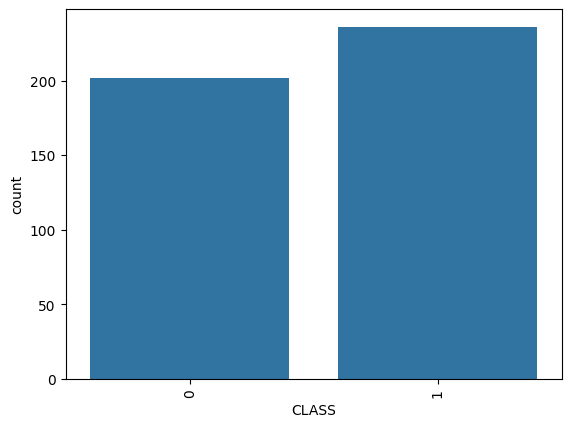

In [20]:
sns.countplot(x="CLASS", data=data)
plt.xticks(rotation=90)
plt.show()

In [21]:
data["COMMENT"].value_counts()

Check out this video on YouTube:﻿                   74
Check out this playlist on YouTube:﻿                15
Love this song makes me wanna dance! ﻿               3
Check out this playlist on YouTube:<br /><br />﻿     2
everyday I&#39;m shufflin﻿                           2
                                                    ..
this song is fu cking awesom!!!!!!!﻿                 1
never gets old﻿                                      1
Party time!﻿                                         1
Damn, this was everywhere﻿                           1
NICE :3﻿                                             1
Name: COMMENT, Length: 340, dtype: int64

In [24]:
classes = list(data["CLASS"])

In [25]:
len(classes)

438

### Convert data to lower case

In [26]:
comments = [c.lower() for c in tqdm(data["COMMENT"])]

100%|██████████| 438/438 [00:00<00:00, 436470.69it/s]


In [25]:
comments[13]

'2011- the last year of decent music.\ufeff'

In [26]:
comments[401]

'check out this video on youtube:\ufeff'

### Tokenize the text

In [27]:
tokens = [word_tokenize(c) for c in tqdm(comments)]

100%|██████████| 438/438 [00:00<00:00, 5280.10it/s]


In [28]:
tokens[13]

['2011-', 'the', 'last', 'year', 'of', 'decent', 'music.\ufeff']

In [29]:
tokens[401]

['check', 'out', 'this', 'video', 'on', 'youtube', ':', '\ufeff']

### Remove stop words

In [28]:
sw = stopwords.words("english")

In [29]:
sw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [32]:
tokens = [[word for word in t if word not in sw] for t in tqdm(tokens)]

100%|██████████| 438/438 [00:00<00:00, 45942.56it/s]


### Remove punctuation marks

In [30]:
tokenizer = RegexpTokenizer(r'\w+')

In [34]:
tokens = [["".join(tokenizer.tokenize(word)) for word in t 
          if len(tokenizer.tokenize(word)) > 0] for t in tqdm(tokens)]

100%|██████████| 438/438 [00:00<00:00, 108962.35it/s]


In [35]:
tokens[13]

['2011', 'last', 'year', 'decent', 'music']

In [36]:
tokens[401]

['check', 'video', 'youtube']

### Remove 'xxxx' and '000' tokens

In [31]:
tokens = [[t for t in token if t not in ['xxxx','000']] for token in tqdm(tokens)]

100%|██████████| 438/438 [00:00<00:00, 218624.91it/s]


In [38]:
tokens[13]

['2011', 'last', 'year', 'decent', 'music']

In [39]:
tokens[401]

['check', 'video', 'youtube']

### Check word count for couple of classes

In [32]:
data["clean_comments"] = tokens

In [33]:
data.head()

,COMMENT,CLASS,clean_comments
0,"<a href=""http://www.youtube.com/watch?v=KQ6zr6...",0,"[<, a, href=, '', http, :, //www.youtube.com/w..."
1,wierd but funny﻿,0,"[wierd, but, funny﻿]"
2,"Hey guys, I&#39;m a human.<br /><br /><br />Bu...",1,"[hey, guys, ,, i, &, #, 39, ;, m, a, human., <..."
3,Party Rock....lol...who wants to shuffle!!!﻿,0,"[party, rock, ...., lol, ..., who, wants, to, ..."
4,Party rock﻿,0,"[party, rock﻿]"


In [34]:
clean_comments = [" ".join(comments) for comments in tqdm(tokens)]

100%|██████████| 438/438 [00:00<00:00, 832022.26it/s]


In [43]:
clean_comments[13]

'2011 last year decent music'

In [44]:
clean_comments[401]

'check video youtube'

In [35]:
nltk.download('punkt')
nltk.download('stopwords')

# Load and explore data
data = pd.read_csv('./Youtube03-LMFAO.csv')
print(data.head())
print(data.info())
# Load stopwords into a set for faster access
stop_words = set(stopwords.words('english'))

# Function to clean text data
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', 'number', text)  # Replace numbers
    return text

# Function to preprocess data using NLTK
def nltk_preprocess(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Removing stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)


# Apply cleaning and preprocessing to the CONTENT column
data['CONTENT'] = data['CONTENT'].apply(clean_text)
data['CONTENT'] = data['CONTENT'].apply(nltk_preprocess)

                              COMMENT_ID        AUTHOR  \
0  z13uwn2heqndtr5g304ccv5j5kqqzxjadmc0k  Corey Wilson   
1  z124jvczaz3dxhnbc04cffk43oiugj25yzo0k   Epic Gaming   
2      z13tczjy5xj0vjmu5231unho1ofey5zdk     LaS Music   
3  z13tzr0hdpnayhqqc04cd3zqqqjkf3ngckk0k    Cheryl Fox   
4  z12pcvix4zedcjvyb04ccr1r0mr2g5xwyng0k    PATRICK_TW   

                         DATE  \
0  2015-05-28T21:39:52.376000   
1  2015-05-28T20:07:20.610000   
2  2015-05-28T19:23:35.355000   
3  2015-05-28T17:49:35.294000   
4  2015-05-28T16:28:26.818000   

                                             CONTENT  CLASS  
0  <a href="http://www.youtube.com/watch?v=KQ6zr6...      0  
1                                   wierd but funny﻿      0  
2  Hey guys, I&#39;m a human.<br /><br /><br />Bu...      1  
3       Party Rock....lol...who wants to shuffle!!!﻿      0  
4                                        Party rock﻿      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Data col

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\badru\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\badru\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Preparation

### Before Applying TF-DIF

In [36]:
# Extracting features from text
count_vectorizer = CountVectorizer()
# count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))
# count_vectorizer = CountVectorizer(ngram_range=(1, 2))  # for bi-grams
# count_vectorizer = CountVectorizer(min_df=200) 

# tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
# X_tfidf = tfidf_vectorizer.fit_transform(data['CONTENT'])


X_counts = count_vectorizer.fit_transform(data['CONTENT'])
print("Shape of Count Vectors:", X_counts.shape)


feature_names = count_vectorizer.get_feature_names_out()

# Print a sample of feature names (tokens)
print("Sample feature names:", feature_names[:10])  

# Summarize the occurrence of the tokens
token_counts = X_counts.sum(axis=0)
token_frequency = [(feature_names[i], token_counts[0, i]) for i in range(token_counts.shape[1])]
sorted_token_frequency = sorted(token_frequency, key=lambda x: x[1], reverse=True)

# Print the 10 most common tokens
print("Most common tokens:", sorted_token_frequency[:10])

Shape of Count Vectors: (438, 802)
Sample feature names: ['__' '______________________________if' 'abomination' 'abonner' 'act'
 'actors' 'actresses' 'actually' 'adoult' 'advertisements']
Most common tokens: [('check', 143), ('number', 137), ('youtube', 128), ('video', 117), ('song', 52), ('subscribe', 52), ('like', 49), ('channel', 31), ('love', 30), ('party', 26)]


In [37]:
# Applying TF-IDF
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print("Shape of TFIDF Vectors:", X_tfidf.shape)

# Display some sample TF-IDF values for the first document
print("Sample of TF-IDF values for the first document:")
print(X_tfidf[0])

# Display the average TF-IDF value for words in all documents (optional)
average_tfidf = X_tfidf.mean(axis=0)
print("Average TF-IDF value for all words in the corpus:")
print(average_tfidf)

Shape of TFIDF Vectors: (438, 802)
Sample of TF-IDF values for the first document:
  (0, 496)	0.6472851526995473
  (0, 470)	0.589751892421225
  (0, 58)	0.48292301299514356
Average TF-IDF value for all words in the corpus:
[[0.00098588 0.00058937 0.00109537 0.00030282 0.00022822 0.00037053
  0.00037053 0.0011715  0.00039686 0.00037792 0.00107972 0.00194348
  0.00134243 0.00121697 0.00046835 0.00132734 0.00038899 0.00128818
  0.00077206 0.00022822 0.00022822 0.00202535 0.00122036 0.00034818
  0.00289355 0.0013555  0.00210521 0.000699   0.00039686 0.0005596
  0.0005596  0.00078013 0.0005596  0.00075583 0.00100145 0.00100559
  0.00060731 0.00140345 0.00145776 0.00126774 0.01218587 0.00321373
  0.00196089 0.00712493 0.00123653 0.0011972  0.0009812  0.00108377
  0.00044146 0.00058444 0.00039686 0.0009242  0.00158472 0.00204755
  0.001189   0.00034818 0.00084618 0.00364005 0.01726588 0.00087199
  0.00108377 0.00432736 0.00140505 0.00083385 0.00061708 0.00099786
  0.00091885 0.00141233 0.00062

### Split the data into train and test

In [38]:
# Shuffle and split data
data_shuffled = data.sample(frac=1).reset_index(drop=True)
X = X_tfidf
y = data_shuffled['CLASS']
train_size = int(0.75 * len(data))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Model Training

### Create a multi-nomial Naive Bayes' Model

In [39]:
classifier = MultinomialNB(alpha=0.1).fit(X_train, y_train)

# Cross-validation
# accuracy_scores = cross_val_score(classifier, X_train, y_train, cv=5)
# print("Mean accuracy from cross-validation:", accuracy_scores.mean())


### Predict on test set

In [40]:

skf = StratifiedKFold(n_splits=5)
accuracy_scores = cross_val_score(classifier, X_train, y_train, cv=skf)
print("Mean accuracy from cross-validation:", accuracy_scores.mean())

# Model testing
y_pred = classifier.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Mean accuracy from cross-validation: 0.4727272727272728
Confusion Matrix:
 [[23 32]
 [21 34]]
Accuracy: 0.5181818181818182


In [41]:
accuracy_score(y_test, y_pred)

0.5181818181818182

### Visualize confusion matrix

In [42]:
conf_mat = confusion_matrix(y_test, y_pred)

In [43]:
conf_mat

array([[23, 32],
       [21, 34]], dtype=int64)

In [44]:

# Assuming 'classifier' is trained Naive Bayes model
conf_mat_df = pd.DataFrame(conf_mat, columns=classifier.classes_, index=classifier.classes_)



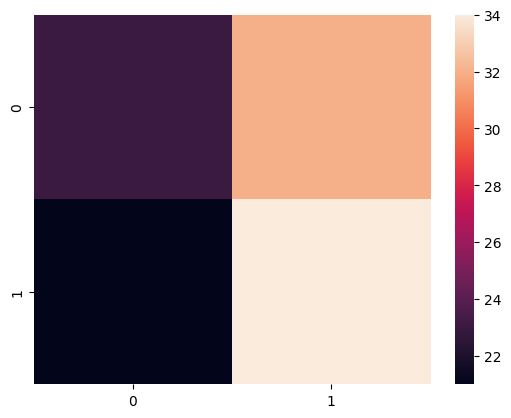

In [45]:
sns.heatmap(conf_mat)
plt.show()

### Save vectorizer and model object

In [46]:
import pickle

# Save the CountVectorizer
with open("Output/count_vectf.pkl", "wb") as f:
    pickle.dump(count_vectorizer, f)

# Save the Naive Bayes classifier
with open("Output/nbf.pkl", "wb") as f:
    pickle.dump(classifier, f)


# Prediction

In [47]:
data["CONTENT"][141]

'man song really get bones one minute number nearly dosing sleep next number shuffling like crazy hot feet xd'

In [60]:
data["CLASS"][141]

0

### Load the vectorizer and model objects

In [48]:
vect = pickle.load(open("Output/count_vect.pkl", "rb"))
model = pickle.load(open("Output/nb.pkl", "rb"))

### Process test data

In [49]:
# Test the model with new comments
new_comments = [
    'I love this song, it reminds me of summer!',  # non-spam
    'This video is very well made, kudos to the director.',  # non-spam
    'Check out my profile for free music!',  # spam
    'Amazing content as always, just subscribed!',  # non-spam
    'Great tutorial, learned a lot from this.',  # non-spam
    'Free games and gift cards, click on my profile!',  # spam
]

# Preprocess new comments
new_comments_processed = [clean_text(comment) for comment in new_comments]
new_comments_processed = [nltk_preprocess(comment) for comment in new_comments_processed]

# Transform new comments using the same vectorizer and transformer
new_comments_counts = count_vectorizer.transform(new_comments_processed)
new_comments_tfidf = tfidf_transformer.transform(new_comments_counts)

# Predict the class for new comments
new_predictions = classifier.predict(new_comments_tfidf)
predictions_labels = ['Spam' if label == 1 else 'Not Spam' for label in new_predictions]

# Print the predictions
for comment, prediction in zip(new_comments, predictions_labels):
    print('\nComment:', comment, '\nPredicted category:', prediction)


Comment: I love this song, it reminds me of summer! 
Predicted category: Not Spam

Comment: This video is very well made, kudos to the director. 
Predicted category: Not Spam

Comment: Check out my profile for free music! 
Predicted category: Not Spam

Comment: Amazing content as always, just subscribed! 
Predicted category: Not Spam

Comment: Great tutorial, learned a lot from this. 
Predicted category: Not Spam

Comment: Free games and gift cards, click on my profile! 
Predicted category: Spam


### Vectorize test data

In [141]:
# Extracting features from text
count_vectorizer = CountVectorizer()
X_counts = count_vectorizer.fit_transform(data['CONTENT'])
print("Shape of Count Vectors:", X_counts.shape)

# Applying TF-IDF
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print("Shape of TFIDF Vectors:", X_tfidf.shape)


Shape of Count Vectors: (438, 802)
Shape of TFIDF Vectors: (438, 802)


In [142]:
# Predict the class for new comments
new_predictions = classifier.predict(new_comments_tfidf)
predictions_labels = ['Spam' if label == 1 else 'Not Spam' for label in new_predictions]

# Print the predictions
for comment, prediction in zip(new_comments, predictions_labels):
    print('\nComment:', comment, '\nPredicted category:', prediction)


Comment: I love this song, it reminds me of summer! 
Predicted category: Spam

Comment: This video is very well made, kudos to the director. 
Predicted category: Not Spam

Comment: Check out my profile for free music! 
Predicted category: Spam

Comment: Amazing content as always, just subscribed! 
Predicted category: Not Spam

Comment: Great tutorial, learned a lot from this. 
Predicted category: Not Spam

Comment: Free games and gift cards, click on my profile! 
Predicted category: Not Spam
